# Import libraries, data

In [1326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
import seaborn as sns

In [1327]:
# import data
oscardata = pd.read_csv('BestActressProject.csv')
oscardata.head()

,year,awardDate,actress,movie,USRelease,winner,age,nationality1,nationality2,nationality3,...,language5,imdb,bestFilmNom,bestFilmWin,bestDirNom,bestDirWin,baftaNom,baftaWinner,globeNom,globeWinner
0,1928,5/16/1929,Gloria Swanson,Sadie Thompson,1/7/1928,No,30,American,NaN,NaN,...,NaN,7.2,No,No,No,No,NaN,NaN,NaN,NaN
1,1928,5/16/1929,Janet Gaynor,7th Heaven,10/30/1927,Yes,22,American,NaN,NaN,...,NaN,7.7,Yes,No,Yes,Yes,NaN,NaN,NaN,NaN
2,1928,5/16/1929,Louise Dresser,A Ship Comes In,1/4/1928,No,51,American,NaN,NaN,...,NaN,5.7,No,No,No,No,NaN,NaN,NaN,NaN
3,1929,4/3/1930,Bessie Love,The Broadway Melody,6/6/1929,No,32,American,NaN,NaN,...,NaN,5.7,Yes,Yes,Yes,No,NaN,NaN,NaN,NaN
4,1929,4/3/1930,Betty Compson,The Barker,12/9/1928,No,33,American,NaN,NaN,...,NaN,6.6,No,No,No,No,NaN,NaN,NaN,NaN


# Preprocessing

In [1328]:
# find and remove any duplicate rows
# check for duplicate rows
oscardata.duplicated().sum()
# create list of duplicate rows
duplicateRowsDF = oscardata[oscardata.duplicated()]
print(duplicateRowsDF)

Empty DataFrame
Columns: [year, awardDate, actress, movie, USRelease, winner, age, nationality1, nationality2, nationality3, prevNoms, prevWins, prevSuppNoms, prevSuppWins, genre1, genre2, genre3, genre4, genre5, genre6, addtlFilmOscars, distributor, runTime, budgetMil, boxOfficeMil, yearCPI, language1, language2, language3, language4, language5, imdb, bestFilmNom, bestFilmWin, bestDirNom, bestDirWin, baftaNom, baftaWinner, globeNom, globeWinner]
Index: []

[0 rows x 40 columns]


In [1329]:
# count missing values for each feature
oscardata.isnull().sum()

year                 0
awardDate            0
actress              0
movie                0
USRelease            0
winner               0
age                  0
nationality1         0
nationality2       391
nationality3       444
prevNoms             0
prevWins             0
prevSuppNoms         0
prevSuppWins         0
genre1               0
genre2              87
genre3             272
genre4             391
genre5             438
genre6             450
addtlFilmOscars      0
distributor          0
runTime              0
budgetMil          123
boxOfficeMil        52
yearCPI              0
language1            0
language2          422
language3          441
language4          447
language5          450
imdb                 0
bestFilmNom          0
bestFilmWin          0
bestDirNom           0
bestDirWin           0
baftaNom           116
baftaWinner        116
globeNom            71
globeWinner         71
dtype: int64

In [1330]:
# replace yes/no features with 1/0

def converter(word):
    if word == 'Yes':
        return 1
    else:
        return 0

fill_cols = ['winner','bestFilmNom','bestFilmWin','bestDirNom','bestDirWin',
             'globeNom','globeWinner','baftaNom','baftaWinner']
oscardata[fill_cols] = oscardata[fill_cols].applymap(converter)

In [1331]:
# add column for decade
oscardata['decade'] = (oscardata['year']//10)*10

In [1332]:
# add column for days between release date and award ceremony date
from datetime import date
oscardata['awardDate'] = pd.to_datetime(oscardata['awardDate'])
oscardata['USRelease'] = pd.to_datetime(oscardata['USRelease'])
oscardata['daysSinceRelease'] = (oscardata['awardDate'] - oscardata['USRelease']).dt.days
oscardata = oscardata.drop(columns=['awardDate','USRelease'])

In [1333]:
# adjust budget, box office performance for inflation
oscardata['budgetAdj'] = oscardata['budgetMil']*(257.346/oscardata['yearCPI'])
oscardata['boxOfficeAdj'] = oscardata['boxOfficeMil']*(257.346/oscardata['yearCPI'])
# remove original budget, box office columns
oscardata.drop(['budgetMil','boxOfficeMil','yearCPI'],axis=1,inplace=True)

In [1334]:
# functions to remove outliers and calculate the mean of a column
def mean_new(x, col):

    # identify outlier cutoff values
    quartile_1, quartile_3 = np.nanpercentile(oscardata[col], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    # calculate mean by decade (with outliers removed)
    mean_var = oscardata[(oscardata[col] < upper_bound) & (oscardata[col] > lower_bound)].groupby('decade')[col].mean().to_dict()
    return mean_var
    
def impute_value(cols):
    
    # impute missing values with the decade mean
    select_column = cols[0]
    decade = cols[1]

    if pd.isnull(select_column):
        return mean_var.get(decade)
    else:
        return select_column

In [1335]:
# impute missing values for budget
mean_var = mean_new(oscardata,'budgetAdj')
oscardata['budgetAdj'] = oscardata[['budgetAdj','decade']].apply(impute_value,axis=1)

In [1336]:
# imput missing values for box office
mean_var = mean_new(oscardata,'boxOfficeAdj')
oscardata['boxOfficeAdj'] = oscardata[['boxOfficeAdj','decade']].apply(impute_value,axis=1)

In [1337]:
# show features with missing values
oscardata.isnull().sum()

year                  0
actress               0
movie                 0
winner                0
age                   0
nationality1          0
nationality2        391
nationality3        444
prevNoms              0
prevWins              0
prevSuppNoms          0
prevSuppWins          0
genre1                0
genre2               87
genre3              272
genre4              391
genre5              438
genre6              450
addtlFilmOscars       0
distributor           0
runTime               0
language1             0
language2           422
language3           441
language4           447
language5           450
imdb                  0
bestFilmNom           0
bestFilmWin           0
bestDirNom            0
bestDirWin            0
baftaNom              0
baftaWinner           0
globeNom              0
globeWinner           0
decade                0
daysSinceRelease      0
budgetAdj             0
boxOfficeAdj          0
dtype: int64

In [1338]:
# create columns identifying if actress is American or British
oscardata['nat_american'] = 0
oscardata.loc[oscardata['nationality1'] == 'American', 'nat_american'] = 1
oscardata.loc[oscardata['nationality2'] == 'American', 'nat_american'] = 1
oscardata.loc[oscardata['nationality3'] == 'American', 'nat_american'] = 1

oscardata['nat_british'] = 0
oscardata.loc[oscardata['nationality1'] == 'British', 'nat_british'] = 1
oscardata.loc[oscardata['nationality2'] == 'British', 'nat_british'] = 1
oscardata.loc[oscardata['nationality3'] == 'British', 'nat_british'] = 1

# create column identifying if English is the primary language of the movie
oscardata['engLangMovie'] = 0
oscardata.loc[oscardata['language1'] == 'English', 'engLangMovie'] = 1

oscardata.drop(['nationality1','nationality2','nationality3','language1',
               'language2','language3','language4','language5'],axis=1,inplace=True)

In [1339]:
# create dummy variables for genre
def dummy_genre(df, col1, col2, col3, col4, col5, col6):
    
    g1 = list(oscardata[col1].dropna())
    g2 = list(oscardata[col2].dropna())
    g3 = list(oscardata[col3].dropna())
    g4 = list(oscardata[col4].dropna())
    g5 = list(oscardata[col5].dropna())
    g6 = list(oscardata[col6].dropna())
    g_list = g1 + g2 + g3 + g4 + g5 + g6
    z = lambda n:sorted(set(n),key=n.count)[::-1]
    genres = z(g_list)[:5]
    
    for i in genres:

        oscardata['genre_'+i] = 0
        oscardata.loc[oscardata[col1] == i, 'genre_'+i] = 1
        oscardata.loc[oscardata[col2] == i, 'genre_'+i] = 1
        oscardata.loc[oscardata[col3] == i, 'genre_'+i] = 1
        oscardata.loc[oscardata[col4] == i, 'genre_'+i] = 1
        oscardata.loc[oscardata[col5] == i, 'genre_'+i] = 1
        oscardata.loc[oscardata[col6] == i, 'genre_'+i] = 1

    oscardata.drop([col1,col2,col3,col4,col5,col6],axis=1,inplace=True)
    
dummy_genre(oscardata,'genre1','genre2','genre3','genre4','genre5','genre6')

In [1340]:
# show features with missing values
oscardata.isnull().sum()

year                0
actress             0
movie               0
winner              0
age                 0
prevNoms            0
prevWins            0
prevSuppNoms        0
prevSuppWins        0
addtlFilmOscars     0
distributor         0
runTime             0
imdb                0
bestFilmNom         0
bestFilmWin         0
bestDirNom          0
bestDirWin          0
baftaNom            0
baftaWinner         0
globeNom            0
globeWinner         0
decade              0
daysSinceRelease    0
budgetAdj           0
boxOfficeAdj        0
nat_american        0
nat_british         0
engLangMovie        0
genre_Drama         0
genre_Romance       0
genre_Comedy        0
genre_Biography     0
genre_Thriller      0
dtype: int64

In [1341]:
oscardata['distributor'].value_counts()

20th Century Fox                          46
Paramount Pictures                        46
Warner Bros.                              44
MGM                                       41
Columbia Pictures                         35
United Artists                            31
Universal Pictures                        21
RKO Radio Pictures                        20
Miramax Films                             15
Sony Pictures Classics                    13
Fox Searchlight Pictures                  13
Loew's                                     7
Focus Features                             7
Sony Pictures Releasing                    7
Lionsgate                                  6
Embassy Pictures                           5
TriStar Pictures                           5
The Weinstein Company                      4
Warner Bros.-Seven Arts                    3
Fine Line Features                         3
Pathe                                      3
October Films                              3
Orion Pict

In [1342]:
# break up distributor column into multiple
oscardata[['distributor1','distributor2']] = oscardata['distributor'].str.split(", ",expand=True,)
oscardata.drop('distributor',axis=1,inplace=True)

In [1343]:
# create dummy variables for top 10 distributors
def dist_list(df, col1, col2):
    
    x1 = list(oscardata[col1].dropna())
    x2 = list(oscardata[col2].dropna())
    x_list = x1 + x2

    z = lambda n:sorted(set(n),key=n.count)[::-1]
    dists = z(x_list)[:5]
    
    for i in dists:

        oscardata['dist_'+i] = 0
        oscardata.loc[oscardata[col1] == i, 'dist_'+i] = 1
        oscardata.loc[oscardata[col2] == i, 'dist_'+i] = 1

    oscardata.drop([col1,col2],axis=1,inplace=True)
    
dist_list(oscardata,'distributor1','distributor2')

In [1344]:
oscardata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 37 columns):
year                       451 non-null int64
actress                    451 non-null object
movie                      451 non-null object
winner                     451 non-null int64
age                        451 non-null int64
prevNoms                   451 non-null int64
prevWins                   451 non-null int64
prevSuppNoms               451 non-null int64
prevSuppWins               451 non-null int64
addtlFilmOscars            451 non-null int64
runTime                    451 non-null int64
imdb                       451 non-null float64
bestFilmNom                451 non-null int64
bestFilmWin                451 non-null int64
bestDirNom                 451 non-null int64
bestDirWin                 451 non-null int64
baftaNom                   451 non-null int64
baftaWinner                451 non-null int64
globeNom                   451 non-null int64
globeWinner      

In [1345]:
# look at correlation coefficient matrix
corrMat = oscardata.corr()
s = corrMat.unstack()
so = s.sort_values(kind="quicksort")
pd.set_option('display.max_rows', 200)
s = corrMat.unstack()
so = s.sort_values(ascending=False)
so

dist_Columbia Pictures   dist_Columbia Pictures     1.000000
globeNom                 globeNom                   1.000000
dist_Paramount Pictures  dist_Paramount Pictures    1.000000
dist_20th Century Fox    dist_20th Century Fox      1.000000
genre_Thriller           genre_Thriller             1.000000
genre_Biography          genre_Biography            1.000000
genre_Comedy             genre_Comedy               1.000000
genre_Romance            genre_Romance              1.000000
genre_Drama              genre_Drama                1.000000
engLangMovie             engLangMovie               1.000000
nat_british              nat_british                1.000000
nat_american             nat_american               1.000000
boxOfficeAdj             boxOfficeAdj               1.000000
budgetAdj                budgetAdj                  1.000000
daysSinceRelease         daysSinceRelease           1.000000
decade                   decade                     1.000000
baftaWinner             

Text(0.5, 1.0, 'oscardata.corr()')

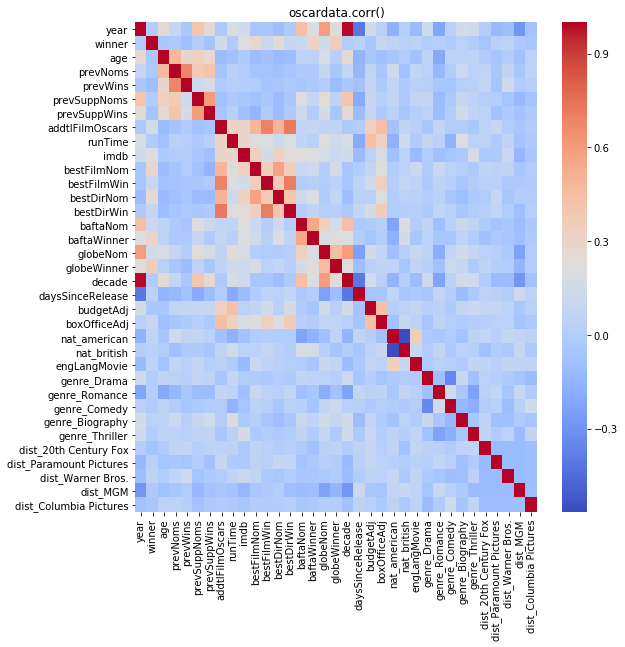

In [1346]:
plt.figure(figsize=(9,9))
sns.heatmap(oscardata.corr(),cmap='coolwarm')
plt.title('oscardata.corr()')

In [1347]:
plt.figure(figsize=(12,9))


<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

# EDA

Text(0.5, 0, 'Age')

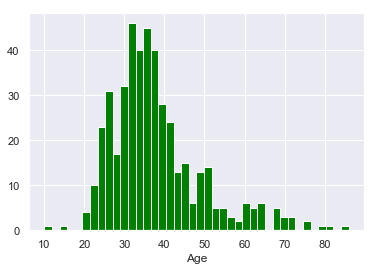

In [1348]:
# Age histogram
sns.set(style='darkgrid')
plt.figure(figsize=(6,4))
oscardata['age'].hist(bins=40,color='green')
plt.xlabel('Age')

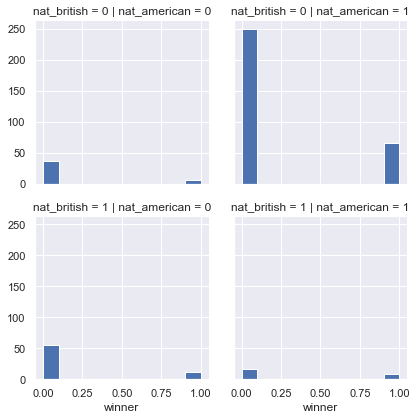

In [1349]:
g = sns.FacetGrid(oscardata, col="nat_american",  row="nat_british")
g = g.map(plt.hist, "winner")

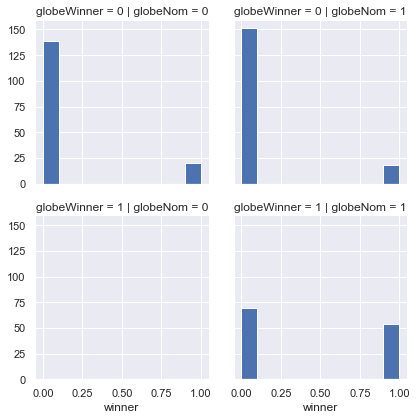

In [1350]:
g = sns.FacetGrid(oscardata, col="globeNom",  row="globeWinner")
g = g.map(plt.hist, "winner")

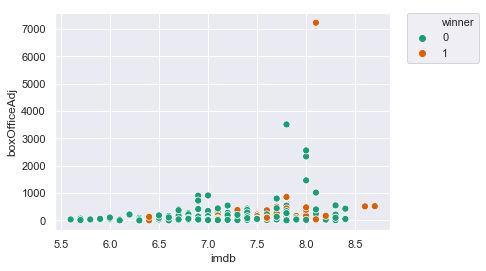

In [1351]:
sns.scatterplot(x='imdb',y='boxOfficeAdj',data=oscardata,hue='winner',palette='Dark2',s=50)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

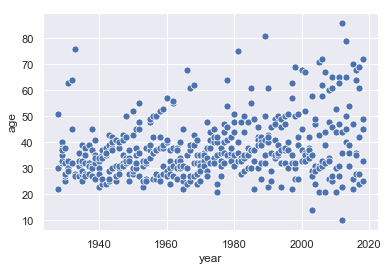

In [1352]:
sns.scatterplot(x='year',y='age',data=oscardata,palette='Dark2',s=50)

### We can see that early on, nominees were more likely to be between 20-50

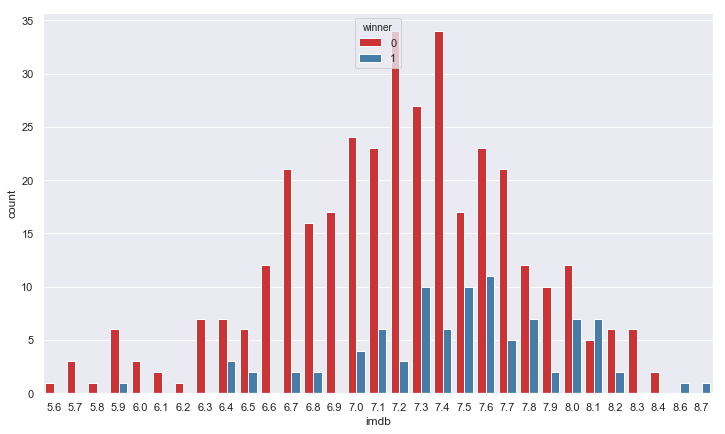

In [1353]:
plt.figure(figsize=(12,7))
sns.countplot(x='imdb',data=oscardata,hue='winner',palette='Set1')

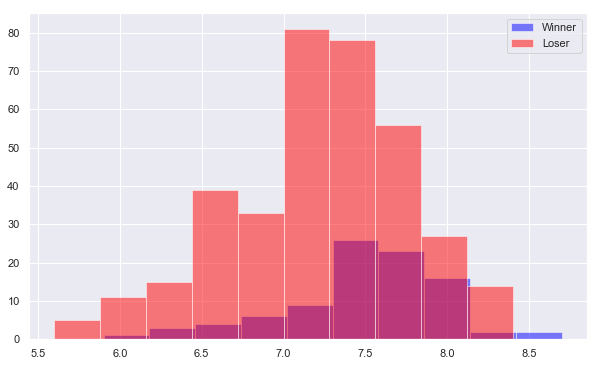

In [1354]:
# Layered histograms
plt.figure(figsize=(10,6))
oscardata[oscardata['winner']==1]['imdb'].hist(alpha=0.5,color='blue',
                                              bins=10,label='Winner')
oscardata[oscardata['winner']==0]['imdb'].hist(alpha=0.5,color='red',
                                              bins=10,label='Loser')
plt.legend()

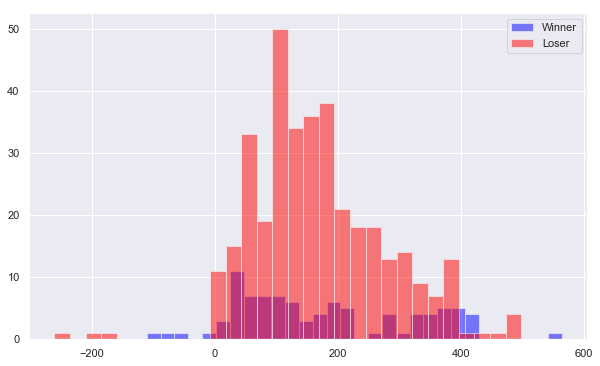

In [1355]:
# Layered histograms
plt.figure(figsize=(10,6))
oscardata[oscardata['winner']==1]['daysSinceRelease'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Winner')
oscardata[oscardata['winner']==0]['daysSinceRelease'].hist(alpha=0.5,color='red',
                                              bins=30,label='Loser')
plt.legend()

# Modeling

In [1356]:
oscardata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 37 columns):
year                       451 non-null int64
actress                    451 non-null object
movie                      451 non-null object
winner                     451 non-null int64
age                        451 non-null int64
prevNoms                   451 non-null int64
prevWins                   451 non-null int64
prevSuppNoms               451 non-null int64
prevSuppWins               451 non-null int64
addtlFilmOscars            451 non-null int64
runTime                    451 non-null int64
imdb                       451 non-null float64
bestFilmNom                451 non-null int64
bestFilmWin                451 non-null int64
bestDirNom                 451 non-null int64
bestDirWin                 451 non-null int64
baftaNom                   451 non-null int64
baftaWinner                451 non-null int64
globeNom                   451 non-null int64
globeWinner      

In [1357]:
X = oscardata.drop(['year','actress','movie','winner','decade'],axis=1)
y = oscardata['winner']

In [1358]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
X = pd.DataFrame(scaled_features,columns=X.columns)
X_copy = pd.DataFrame(scaled_features,columns=X.columns)
X.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,age,prevNoms,prevWins,prevSuppNoms,prevSuppWins,addtlFilmOscars,runTime,imdb,bestFilmNom,bestFilmWin,...,genre_Drama,genre_Romance,genre_Comedy,genre_Biography,genre_Thriller,dist_20th Century Fox,dist_Paramount Pictures,dist_Warner Bros.,dist_MGM,dist_Columbia Pictures
0,-0.676262,-0.59101,-0.567415,-0.484554,-0.294528,-0.503486,-1.175840,-0.119139,-0.763188,-0.266944,...,0.280976,-0.958723,-0.506229,-0.432252,-0.332923,-0.337017,-0.337017,-0.332923,-0.324642,-0.29006
1,-1.371207,-0.59101,-0.567415,-0.484554,-0.294528,0.812875,-0.294011,0.797785,1.310293,-0.266944,...,0.280976,1.043055,-0.506229,-0.432252,-0.332923,-0.337017,-0.337017,-0.332923,-0.324642,-0.29006
2,1.147970,-0.59101,-0.567415,-0.484554,-0.294528,-0.503486,-2.150493,-2.869912,-0.763188,-0.266944,...,0.280976,-0.958723,-0.506229,-0.432252,-0.332923,-0.337017,-0.337017,-0.332923,-0.324642,-0.29006
3,-0.502526,-0.59101,-0.567415,-0.484554,-0.294528,0.154694,-0.758132,-2.869912,1.310293,3.746109,...,0.280976,1.043055,-0.506229,-0.432252,-0.332923,-0.337017,-0.337017,-0.332923,3.080320,-0.29006
4,-0.415657,-0.59101,-0.567415,-0.484554,-0.294528,-0.503486,-1.361488,-1.219448,-0.763188,-0.266944,...,0.280976,1.043055,-0.506229,-0.432252,-0.332923,-0.337017,-0.337017,3.003701,-0.324642,-0.29006


In [1359]:
# Split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)

In [1360]:
# set up model running and results printout
model_list = []
def print_model_results(model,name,initial):
    accept1 = "dtree"
    accept2 = "rfor"
    accept3 = "gbm"
    print()
    print('[' + name + ']')
    print()
    print('Accuracy of classifier on training set: {:.2f}'
         .format(model.score(X_train, y_train)))
    print('Accuracy of classifier on test set: {:.2f}'
         .format(model.score(X_test, y_test)))
    model_pred = model.predict(X_test)
    print()
    print("-----------------------------------------------------------")
    print()
    print(pd.crosstab(y_test, model_pred, rownames=['Actual'], colnames=['Predicted']))
    print()
    print("-----------------------------------------------------------")
    print()
    print(classification_report(y_test, model_pred))
    model_list.append([name, model.score(X_test, y_test)])
    if initial == accept1 or initial == accept2 or initial == accept3:
        plt.figure(figsize=(12,9))
        var_importance = (pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True).plot(kind='barh'))
        plt.title("Variable Importance to Win/Lose")
        plt.xlabel("Correlation Score")
        plt.show()
    else:
        None
    print("-----------------------------------------------------------")
    print()
    print("[Tuning Parameters]")
    print()
    print(model.get_params())

In [1361]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg_name = "Logistic Regression"
logreg_init = "logreg"
logreg.fit(X_train, y_train)
print_model_results(logreg,logreg_name,logreg_init)


[Logistic Regression]

Accuracy of classifier on training set: 0.84
Accuracy of classifier on test set: 0.79

-----------------------------------------------------------

Predicted   0  1
Actual          
0          68  3
1          16  4

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        71
           1       0.57      0.20      0.30        20

   micro avg       0.79      0.79      0.79        91
   macro avg       0.69      0.58      0.59        91
weighted avg       0.76      0.79      0.75        91

-----------------------------------------------------------

[Tuning Parameters]

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



[Random Forest]

Accuracy of classifier on training set: 1.00
Accuracy of classifier on test set: 0.82

-----------------------------------------------------------

Predicted   0  1
Actual          
0          69  2
1          14  6

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.83      0.97      0.90        71
           1       0.75      0.30      0.43        20

   micro avg       0.82      0.82      0.82        91
   macro avg       0.79      0.64      0.66        91
weighted avg       0.81      0.82      0.79        91



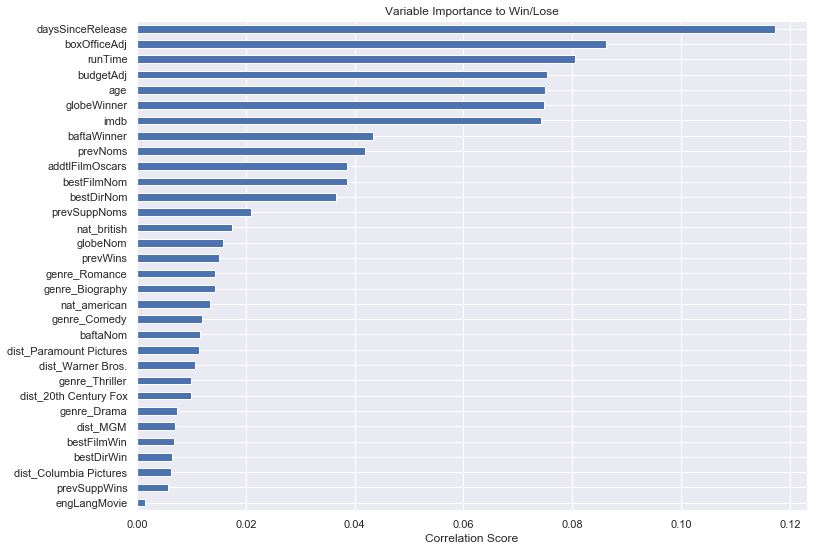

-----------------------------------------------------------

[Tuning Parameters]

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 600, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [1362]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfor = RandomForestClassifier(n_estimators=600)
rfor_name = "Random Forest"
rfor_init = "rfor"
rfor.fit(X_train, y_train)
print_model_results(rfor,rfor_name,rfor_init)


[Decision Tree]

Accuracy of classifier on training set: 1.00
Accuracy of classifier on test set: 0.70

-----------------------------------------------------------

Predicted   0   1
Actual           
0          56  15
1          12   8

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.82      0.79      0.81        71
           1       0.35      0.40      0.37        20

   micro avg       0.70      0.70      0.70        91
   macro avg       0.59      0.59      0.59        91
weighted avg       0.72      0.70      0.71        91



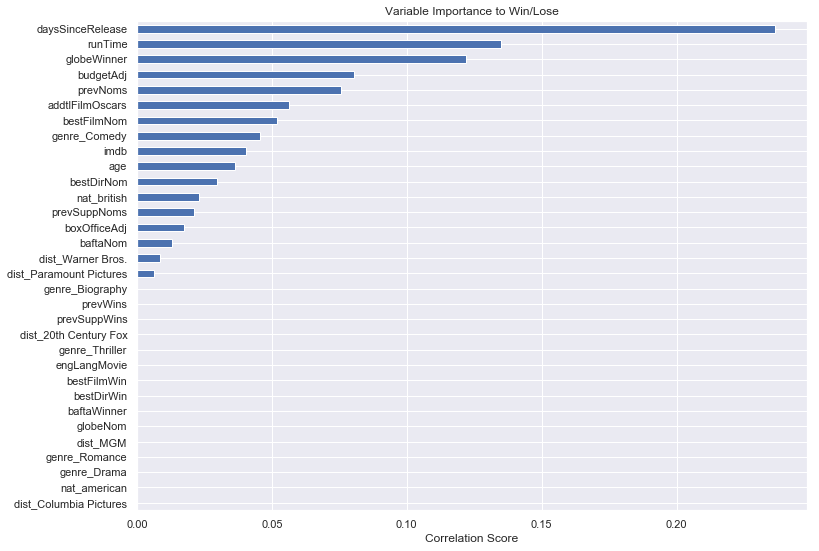

-----------------------------------------------------------

[Tuning Parameters]

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}


In [1363]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree_name = "Decision Tree"
dtree_init = "dtree"
dtree.fit(X_train, y_train)
print_model_results(dtree,dtree_name,dtree_init)


[Gradient Boosting]

Accuracy of classifier on training set: 0.99
Accuracy of classifier on test set: 0.81

-----------------------------------------------------------

Predicted   0  1
Actual          
0          67  4
1          13  7

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        71
           1       0.64      0.35      0.45        20

   micro avg       0.81      0.81      0.81        91
   macro avg       0.74      0.65      0.67        91
weighted avg       0.79      0.81      0.79        91



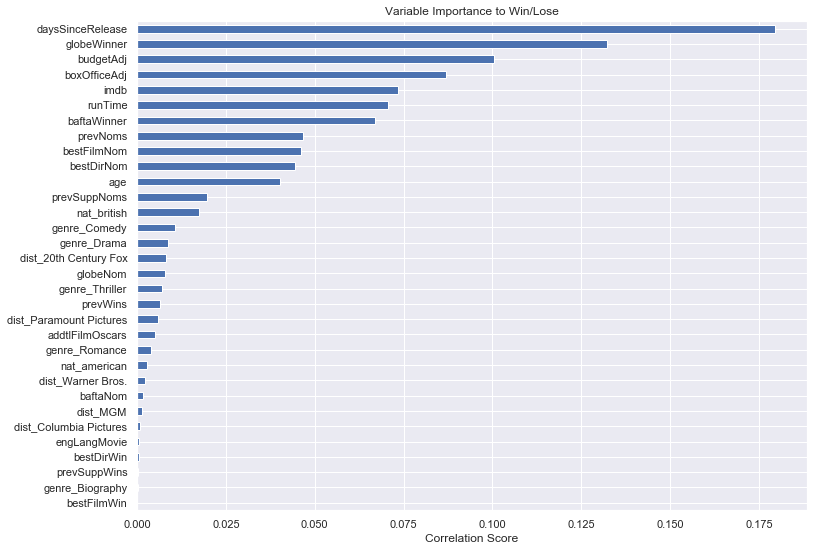

-----------------------------------------------------------

[Tuning Parameters]

{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [1364]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
gbm_name = "Gradient Boosting"
gbm_init = "gbm"
gbm.fit(X_train, y_train)
print_model_results(gbm,gbm_name,gbm_init)

In [1365]:
# Knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=12)
knn_name = "Knn"
knn_init = "knn"
knn.fit(X_train, y_train)
print_model_results(knn,knn_name,knn_init)


[Knn]

Accuracy of classifier on training set: 0.83
Accuracy of classifier on test set: 0.80

-----------------------------------------------------------

Predicted   0  1
Actual          
0          71  0
1          18  2

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        71
           1       1.00      0.10      0.18        20

   micro avg       0.80      0.80      0.80        91
   macro avg       0.90      0.55      0.53        91
weighted avg       0.84      0.80      0.73        91

-----------------------------------------------------------

[Tuning Parameters]

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 12, 'p': 2, 'weights': 'uniform'}


In [1366]:
# SVM
from sklearn.svm import SVC
svm = SVC()
svm_name = "SVM"
svm_init = "svm"
svm.fit(X_train, y_train)
print_model_results(svm,svm_name,svm_init)


[SVM]

Accuracy of classifier on training set: 0.88
Accuracy of classifier on test set: 0.79

-----------------------------------------------------------

Predicted   0  1
Actual          
0          70  1
1          18  2

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.80      0.99      0.88        71
           1       0.67      0.10      0.17        20

   micro avg       0.79      0.79      0.79        91
   macro avg       0.73      0.54      0.53        91
weighted avg       0.77      0.79      0.73        91

-----------------------------------------------------------

[Tuning Parameters]

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [1367]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
naiveb = GaussianNB()
naiveb_name = "Naive Bayes"
naiveb_init = "naiveb"
naiveb.fit(X_train, y_train)
print_model_results(naiveb,naiveb_name,naiveb_init)


[Naive Bayes]

Accuracy of classifier on training set: 0.31
Accuracy of classifier on test set: 0.30

-----------------------------------------------------------

Predicted   0   1
Actual           
0          10  61
1           3  17

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.77      0.14      0.24        71
           1       0.22      0.85      0.35        20

   micro avg       0.30      0.30      0.30        91
   macro avg       0.49      0.50      0.29        91
weighted avg       0.65      0.30      0.26        91

-----------------------------------------------------------

[Tuning Parameters]

{'priors': None, 'var_smoothing': 1e-09}


In [1368]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_name = "LDA"
lda_init = "lda"
lda.fit(X_train, y_train)
print_model_results(lda,lda_name,lda_init)


[LDA]

Accuracy of classifier on training set: 0.84
Accuracy of classifier on test set: 0.80

-----------------------------------------------------------

Predicted   0  1
Actual          
0          66  5
1          13  7

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        71
           1       0.58      0.35      0.44        20

   micro avg       0.80      0.80      0.80        91
   macro avg       0.71      0.64      0.66        91
weighted avg       0.78      0.80      0.78        91

-----------------------------------------------------------

[Tuning Parameters]

{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}


In [1369]:
# see models compared by accuracy
comparison_cols = ['Model', 'Accuracy']
models_compared = pd.DataFrame(model_list, columns=comparison_cols)
models_compared = models_compared.sort_values(by=['Accuracy'], ascending = [False])
models_compared

,Model,Accuracy
1,Random Forest,0.824176
3,Gradient Boosting,0.813187
4,Knn,0.802198
7,LDA,0.802198
0,Logistic Regression,0.791209
5,SVM,0.791209
2,Decision Tree,0.703297
6,Naive Bayes,0.296703


# Predictions

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)

In [ ]:
# try different values between 1 and 40

pca_error_rate = []

# Will take some time
for i in range(1,40):
    
    pca = PCA(n_components=i)
    pca.fit(X_copy)
    X = pca.transform(X_copy)
    
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)
    
    rfor = RandomForestClassifier()
    rfor.fit(X_train, y_train)
    pred_i = rfor.predict(X_test)
    pca_error_rate.append(np.mean(pred_i != y_test))

In [ ]:
# plot error rates at different k values
plt.figure(figsize=(10,6))
plt.plot(range(1,40),pca_error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Error Rate')
# pick the k value where an increase in k value no longer leads to a decrease in error rate

# Knn Tuning

In [ ]:
# try different k values between 1 and 40

error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [ ]:
# plot error rates at different k values
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
# pick the k value where an increase in k value no longer leads to a decrease in error rate